In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from six.moves import cPickle

/vol/optdcc/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Import dataset
train, test = datasets.get_mnist()

In [4]:
def get_batch(batch_size):
    batch_indices = np.random.choice(range(len(train)), size=(batch_size,), replace=False)
    return np.array([np.reshape(train[k][0], newshape=(1,28,28)) for k in batch_indices])

In [5]:
def get_random_input(batch_size, n_hidden):
    return np.random.normal(0,1,size=(batch_size, n_hidden)).astype("float32")

In [6]:
def plot_generated_images(generator, n_images=5):
    # Generate Images
    z = get_random_input(n_hidden=generator.n_hidden, batch_size=n_images)
    images = generator(z).data
    
    #Plot Images
    f, axis = plt.subplots(1, n_images, sharey=True)
    for index, ax in enumerate(axis):
        ax.imshow(images[index,0,:,:])
    plt.title("Generated Images")

In [7]:
class Generator(chainer.Chain):
    def __init__(self, n_hidden, bottom_width=3, ch=512, wscale=0.02):
        super(Generator, self).__init__()
        self.n_hidden = n_hidden
        self.ch = ch
        self.bottom_width = bottom_width

        with self.init_scope():
            w = chainer.initializers.Normal(wscale)
            self.l0 = L.Linear(in_size=n_hidden, out_size=bottom_width*bottom_width*ch, initialW=w)

            self.dc1 = L.Deconvolution2D(in_channels=ch, out_channels=ch//2, ksize=2, stride=2, pad=1, initialW=w)
            self.dc2 = L.Deconvolution2D(in_channels=ch//2, out_channels=ch//4, ksize=2, stride=2, pad=1, initialW=w)
            self.dc3 = L.Deconvolution2D(in_channels=ch//4, out_channels=ch//8, ksize=2, stride=2, pad=1, initialW=w)
            self.dc4 = L.Deconvolution2D(in_channels=ch//8, out_channels=1, ksize=3, stride=3, pad=1, initialW=w)

            # self.bn0 = L.BatchNormalization(size=self.bottom_width*self.bottom_width*self.ch)
            self.bn1 = L.BatchNormalization(size=ch)
            self.bn2 = L.BatchNormalization(size=ch//2)
            self.bn3 = L.BatchNormalization(size=ch//4)
            self.bn4 = L.BatchNormalization(size=ch//8)

    def make_hidden(self, batchsize):
        return numpy.random.uniform(-1, 1, (batchsize, self.n_hidden, 1, 1)).astype(numpy.float32)

    def __call__(self, z):
        h = self.l0(z)
        h = F.reshape(h, (len(z), self.ch, self.bottom_width, self.bottom_width))
        h = F.relu(self.bn1(h))
        h = F.relu(self.bn2(self.dc1(h)))
        h = F.relu(self.bn3(self.dc2(h)))
        h = F.relu(self.bn4(self.dc3(h)))
        x = F.sigmoid(self.dc4(h))
        # x = F.tanh(self.dc4(h))

        return x
    
class Discriminator(chainer.Chain):
    def __init__(self, bottom_width=3, ch=512, wscale=0.02):
        w = chainer.initializers.Normal(wscale)
        super(Discriminator, self).__init__()
        with self.init_scope():

            self.c0 = L.Convolution2D(in_channels=1, out_channels=64, ksize=3, stride=3, pad=1, initialW=w)
            self.c1 = L.Convolution2D(in_channels=ch//8, out_channels=128, ksize=2, stride=2, pad=1, initialW=w)
            self.c2 = L.Convolution2D(in_channels=ch//4, out_channels=256, ksize=2, stride=2, pad=1, initialW=w)
            self.c3 = L.Convolution2D(in_channels=ch//2, out_channels=512, ksize=2, stride=2, pad=1, initialW=w)

            # self.l4 = L.Linear(in_size=bottom_width*bottom_width*ch, out_size=1, initialW=w)
            self.l4 = L.Linear(in_size=None, out_size=1, initialW=w)

            # self.bn0 = L.BatchNormalization(size=ch//8, use_gamma=False)
            self.bn1 = L.BatchNormalization(size=ch//4, use_gamma=False)
            self.bn2 = L.BatchNormalization(size=ch//2, use_gamma=False)
            self.bn3 = L.BatchNormalization(size=ch//1, use_gamma=False)


    def __call__(self, x):
        h = F.leaky_relu(self.c0(x))
        h = F.leaky_relu(self.bn1(self.c1(h)))
        h = F.leaky_relu(self.bn2(self.c2(h)))
        h = F.leaky_relu(self.bn3(self.c3(h)))
        y = self.l4(h)

        return y

In [8]:
def train_wGAN(n_iter, batch_size, generator, discriminator, regularization = 0.):
    
    # Setup Optimizers
    gen_optimizer = optimizers.Adam(alpha=0.001, beta1=0.9, beta2=0.999, eps=1e-08)
    gen_optimizer.setup(generator)
    dis_optimizer = optimizers.Adam(alpha=0.00001, beta1=0.9, beta2=0.999, eps=1e-08)
    dis_optimizer.setup(discriminator)
    
    #Train
    for itr in range(n_iter):
        #Clear gradients
        generator.cleargrads()
        discriminator.cleargrads()
        
        # Sample real batch
        real_batch = get_batch(batch_size)
        
        # Generate batch
        latent = get_random_input(batch_size, generator.n_hidden)
        generated_batch = generator(latent)
        
        # Compute loss
        gen_loss = wGAN_loss(discriminator, generated_batch, real_batch, squared=False)
        
        # Update Generator
        gen_loss.backward()
        gen_optimizer.update()
        
        # Update discriminator
        discriminator.cleargrads()
        reg_loss = wGAN_regularization(discriminator, real_batch)
        (-gen_loss + regularization*reg_loss).backward()
        dis_optimizer.update()
        
        # Plot Images
        print("Iteration: {}, loss: {}, reg: {}".format(itr,gen_loss.data,reg_loss.data))
        if itr%100 == 0:
            plot_generated_images(generator, n_images=5)    

In [9]:
def wGAN_loss(discriminator, generated_batch, train_batch, squared=False):
    gen_loss = F.mean(discriminator(generated_batch)) - F.mean(discriminator(train_batch))
    if squared:
        gen_loss = gen_loss**2
    return gen_loss

In [10]:
def wGAN_regularization(discriminator, train_batch):
    batch_size = np.shape(train_batch)[0]
    half_batch_1 = train_batch[:batch_size/2,:,:,:]
    half_batch_2 = train_batch[batch_size/2:,:,:,:]
    in_difference = F.sqrt(F.sum((half_batch_1 - half_batch_2)**2,axis=(1,2,3)))
    out_difference = F.sum(F.absolute(discriminator(half_batch_1) - discriminator(half_batch_2)), axis=1)
    loss = F.mean(F.relu(out_difference - in_difference)**2)
    return loss

In [11]:
n_hidden = 50
generator = Generator(n_hidden=n_hidden)

In [12]:
discriminator = Discriminator()

In [ ]:
train_wGAN(n_iter=2000, batch_size=50, generator=generator, discriminator=discriminator, regularization = 10.)

Iteration: 0, loss: 6.83500146866, reg: 0.0
Iteration: 1, loss: 6.52949810028, reg: 0.0
Iteration: 2, loss: 6.48291730881, reg: 0.0
Iteration: 3, loss: 6.57677459717, reg: 0.0
Iteration: 4, loss: 6.20837831497, reg: 0.0
Iteration: 5, loss: 6.09701824188, reg: 0.0
Iteration: 6, loss: 5.94340658188, reg: 0.0
Iteration: 7, loss: 6.07276725769, reg: 0.0
Iteration: 8, loss: 6.03432846069, reg: 0.0
Iteration: 9, loss: 6.32420921326, reg: 0.0
Iteration: 10, loss: 6.46693897247, reg: 0.0
Iteration: 11, loss: 6.47410011292, reg: 0.0
Iteration: 12, loss: 6.38352966309, reg: 0.0
Iteration: 13, loss: 6.07825183868, reg: 0.0
Iteration: 14, loss: 6.13002252579, reg: 0.0
Iteration: 15, loss: 6.16052246094, reg: 0.0
Iteration: 16, loss: 6.1343870163, reg: 0.0
Iteration: 17, loss: 6.15612125397, reg: 0.0
Iteration: 18, loss: 5.73535919189, reg: 0.0
Iteration: 19, loss: 6.07588005066, reg: 0.0
Iteration: 20, loss: 6.02744150162, reg: 0.0
Iteration: 21, loss: 5.88344240189, reg: 0.0
Iteration: 22, loss: 

Iteration: 181, loss: 2.4051835537, reg: 0.0
Iteration: 182, loss: 2.54642319679, reg: 0.0
Iteration: 183, loss: 2.64255428314, reg: 0.0
Iteration: 184, loss: 2.64531207085, reg: 0.0
Iteration: 185, loss: 2.65293931961, reg: 0.0
Iteration: 186, loss: 2.1090862751, reg: 0.0
Iteration: 187, loss: 2.55027961731, reg: 0.0
Iteration: 188, loss: 2.40825653076, reg: 0.0
Iteration: 189, loss: 2.46527600288, reg: 0.0
Iteration: 190, loss: 1.99017941952, reg: 0.0
Iteration: 191, loss: 1.76657676697, reg: 0.0
Iteration: 192, loss: 2.16481685638, reg: 0.0
Iteration: 193, loss: 1.93088388443, reg: 0.0
Iteration: 194, loss: 1.58479690552, reg: 0.0
Iteration: 195, loss: 1.73540735245, reg: 0.0
Iteration: 196, loss: 1.43326330185, reg: 0.0
Iteration: 197, loss: 1.4669380188, reg: 0.0
Iteration: 198, loss: 1.50754916668, reg: 0.0
Iteration: 199, loss: 1.43736195564, reg: 0.0
Iteration: 200, loss: 1.29206109047, reg: 0.0
Iteration: 201, loss: 1.20288598537, reg: 0.0
Iteration: 202, loss: 0.842690944672,

Iteration: 359, loss: 0.92530143261, reg: 0.0
Iteration: 360, loss: 1.16173696518, reg: 0.0
Iteration: 361, loss: 1.10095453262, reg: 0.0
Iteration: 362, loss: 1.31960082054, reg: 0.0
Iteration: 363, loss: 1.07620930672, reg: 0.0
Iteration: 364, loss: 1.24508273602, reg: 0.0
Iteration: 365, loss: 0.905781030655, reg: 0.0
Iteration: 366, loss: 0.904014706612, reg: 0.0
Iteration: 367, loss: 1.01084160805, reg: 0.0
Iteration: 368, loss: 1.32914292812, reg: 0.0
Iteration: 369, loss: 0.7894500494, reg: 0.0
Iteration: 370, loss: 0.982407212257, reg: 0.0
Iteration: 371, loss: 1.21973526478, reg: 0.0
Iteration: 372, loss: 0.68829035759, reg: 0.0
Iteration: 373, loss: 0.94842672348, reg: 0.0
Iteration: 374, loss: 0.853897213936, reg: 0.0
Iteration: 375, loss: 0.723544836044, reg: 0.0
Iteration: 376, loss: 0.807867288589, reg: 0.0
Iteration: 377, loss: 0.753534317017, reg: 0.0
Iteration: 378, loss: 0.615457177162, reg: 0.0
Iteration: 379, loss: 0.741141438484, reg: 0.0
Iteration: 380, loss: 0.28

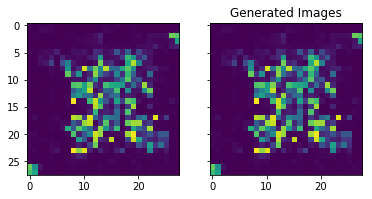

In [29]:
plot_generated_images(generator, n_images=2)

In [15]:
real = get_batch(batch_size=10)
discriminator(real)

variable([[ 0.48011446],
          [ 0.64108396],
          [-0.08177859],
          [-0.08548088],
          [ 0.7578274 ],
          [ 0.63911   ],
          [ 2.23181   ],
          [ 0.5814978 ],
          [-0.1326409 ],
          [ 0.34209228]])

In [16]:
z = get_random_input(10, generator.n_hidden)
fake = generator(z)
discriminator(fake)

variable([[0.4707209 ],
          [0.6744638 ],
          [0.43337902],
          [0.3057451 ],
          [0.41185305],
          [0.69154465],
          [0.5045203 ],
          [0.36493284],
          [0.35525772],
          [0.35493848]])